In [6]:
import os, sys, time, glob, warnings
from os.path import join as joindir
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib import colors as mplcolors
import numpy as np, pandas as pd, xarray as xr
from numpy import datetime64 as dt64, timedelta64 as td64

warnings.filterwarnings('ignore')

def doy(theDatetime): return 1 + int((theDatetime - dt64(str(theDatetime)[0:4] + '-01-01')) / td64(1, 'D'))
def dt64_from_doy(year, doy): return dt64(str(year) + '-01-01') + td64(doy-1, 'D')
def day_of_month_to_string(d): return str(d) if d > 9 else '0' + str(d)

print('\nJupyter Notebook running Python {}'.format(sys.version_info[0]))


Jupyter Notebook running Python 3


In [9]:
s=xr.open_dataset("../../../data/ocean/glodap/NO3.nc")
s

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

In [44]:
s.zooplankton


<xarray.DataArray 'zooplankton' (ocean_time: 8761, s_rho: 30)>
[262830 values with dtype=float32]
Coordinates:
    lat_rho     float64 44.53
    lat_u       float64 44.53
    lat_v       float64 44.54
    lon_rho     float64 -125.4
    lon_u       float64 -125.4
    lon_v       float64 -125.4
  * ocean_time  (ocean_time) datetime64[ns] 2021-01-01 ... 2022-01-01
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
Attributes:
    long_name:     zooplankton concentration
    units:         millimole_nitrogen meter-3
    time:          ocean_time
    grid:          grid
    location:      face
    field:         zooplankton, scalar, series
    cell_methods:  ocean_time: mean

In [30]:
# getting out the 30 'rho' cell-center water column depths
#   negative down from 0; notice order is from seafloor to surface
time_index = 2700      # arbitrary
for i in [0, 1, 2, 3, 4, 25, 26, 27, 28, 29]:
    print(s.z_rho[17][i].data)

-2871.245108889523
-2727.372688756239
-2569.4996189028075
-2401.0827602746313
-2225.807907830217
-49.135333725741646
-29.825412488138365
-15.479155217876974
-5.908780558473932
-0.9888833421403472


In [31]:
# s.shflux is surface net heat flux
# s.swrad is solar shortwave radiation flux
# s.zeta is free surface (height relative to mean)
# s.NO3 is nitrate concentration (millimole_nitrogen meter-3)
# s.phytoplankton is phytoplankton concentration (millimole_nitrogen meter-3)
# s.rho is density anomaly (kg m-3)
# s.salt is salinity (g kg-1)


--------------------time step of mooring--------------------
3600.0
------------------------time limits-------------------------
start 2021-01-01 00:00:00
end   2022-01-01 00:00:00
----------------------------info----------------------------
AKs                  ( salinity vertical diffusion coefficient ) (8761, 31)
AKv                  ( vertical viscosity coefficient ) (8761, 31)
Cs_r                 ( S-coordinate stretching curves at RHO-points ) (30,)
Cs_w                 ( S-coordinate stretching curves at W-points ) (31,)
Ldetritus            ( Ldetritus concentration ) (8761, 30)
NO3                  ( nitrate concentration ) (8761, 30)
Pair                 ( surface air pressure ) (8761,)
TIC                  ( total inorganic carbon ) (8761, 30)
Uwind                ( surface u-wind component ) (8761,)
Vwind                ( surface v-wind component ) (8761,)
alkalinity           ( total alkalinity ) (8761, 30)
bustr                ( bottom u-momentum stress ) (8761,)
bvstr  

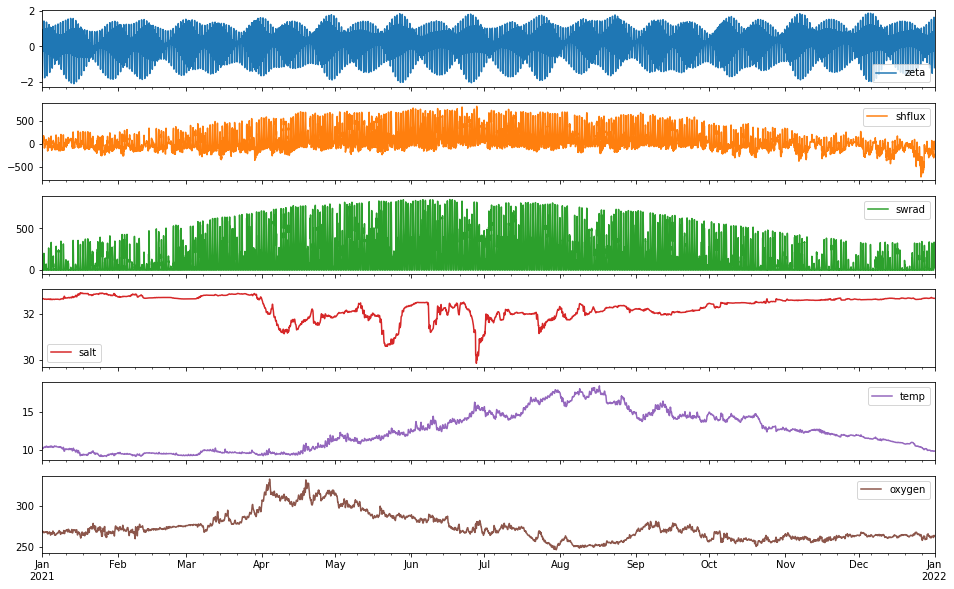

In [45]:
# Modified version of Parker's code; key features:
#   renamed Parker's T as 'Tpm' to avoid collisions

ds = xr.load_dataset(roms_datafile)
ot = ds.ocean_time.values
ot_dt = pd.to_datetime(ot)
t = (ot_dt - ot_dt[0]).total_seconds().to_numpy()
Tpm = t/86400 # time in days from start

print('time step of mooring'.center(60,'-'))
print(t[1])
print('time limits'.center(60,'-'))
print('start ' + str(ot_dt[0]))
print('end   ' + str(ot_dt[-1]))
print('info'.center(60,'-'))

VN_list = []
for vn in ds.data_vars:
    if not (vn == 'z_rho' or vn == 'z_w'):
        vnlj = vn.ljust(20, ' ')
        print('%s ( %s ) %s' % (vnlj, ds[vn].long_name, ds[vn].shape))
        VN_list.append(vn)
    
# populate lists of variables to plot
vn2_list = ['zeta']
if 'shflux' in VN_list:
    vn2_list += ['shflux', 'swrad']
vn3_list = []
if 'salt' in VN_list:
    vn3_list += ['salt', 'temp']
if 'oxygen' in VN_list:
    vn3_list += ['oxygen']

# plot time series using a pandas DataFrame
df = pd.DataFrame(index=ot)
for vn in vn2_list:
    df[vn] = ds[vn].values
for vn in vn3_list:
    # the -1 means surface values (order 0...-1 is from seafloor to surface)
    df[vn] = ds[vn][:, -1].values

plt.close('all')
df.plot(subplots=True, figsize=(16,10))
plt.show()

### Parker's chart code

Compressed a bit for space. Modified version is used above to produce those charts. 


```
"""
Stand-alone code to plot a user-specified mooring extraction.
"""
from pathlib import Path
moor_fn = Path('...etcetera....nc')
import xarray as xr, matplotlib.pyplot as plt, pandas as pd, numpy as np

# load everything using xarray
ds = xr.load_dataset(moor_fn)
ot = ds.ocean_time.values
ot_dt = pd.to_datetime(ot)
t = (ot_dt - ot_dt[0]).total_seconds().to_numpy()
T = t/86400 # time in days from start
print('time step of mooring'.center(60,'-'))
print(t[1])
print('time limits'.center(60,'-'))
print('start ' + str(ot_dt[0]))
print('end   ' + str(ot_dt[-1]))
print('info'.center(60,'-'))
VN_list = []
for vn in ds.data_vars:
    print('%s %s' % (vn, ds[vn].shape))
    VN_list.append(vn)
    
# populate lists of variables to plot
vn2_list = ['zeta']
if 'shflux' in VN_list:
    vn2_list += ['shflux', 'swrad']
vn3_list = []
if 'salt' in VN_list:
    vn3_list += ['salt', 'temp']
if 'oxygen' in VN_list:
    vn3_list += ['oxygen']

# plot time series using a pandas DataFrame
df = pd.DataFrame(index=ot)
for vn in vn2_list:
    df[vn] = ds[vn].values
for vn in vn3_list:
    # the -1 means surface values
    df[vn] = ds[vn][:, -1].values

plt.close('all')
df.plot(subplots=True, figsize=(16,10))
plt.show()
```